# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

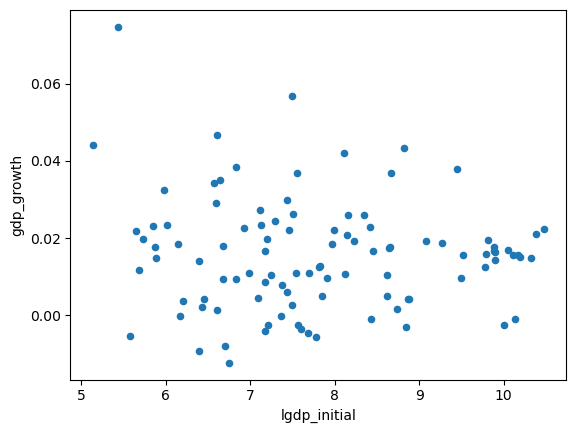

In [3]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

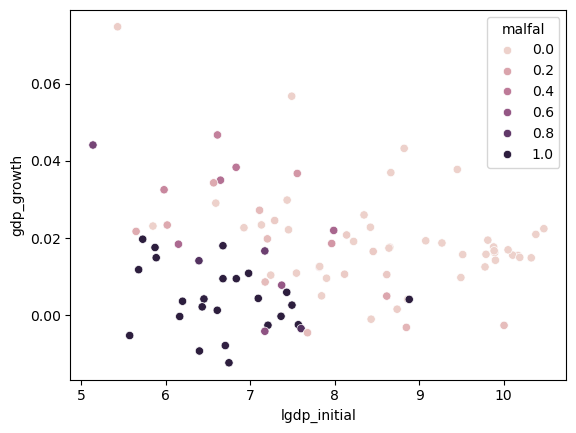

In [4]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [5]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [6]:
dat.isnull().sum() # check for missing values

code                 0
marketref           78
dem                 59
demCGV              64
demBMR              60
                  ... 
investment_rate     35
gdp_growth         112
pop_growth          16
lgdp_initial       105
lpop_initial        15
Length: 85, dtype: int64

# Prepare data

In [7]:
vs = vv_all['geography'] + vv_all['institutions']
xs = ['pop_growth', 'investment_rate', 'yellow', 'malfal'] + vs

# avoiding missings
all_vars = ['gdp_growth', 'lgdp_initial'] + xs
I = dat[all_vars].notnull().all(axis=1)

# extract data
Z_basic = dat.loc[I, xs].values
D = dat.loc[I, 'lgdp_initial']
y = dat.loc[I,'gdp_growth'] * 100. #easier to read output when growth is in 100%

In [8]:
# Add polynomial features. We add interaction terms and quadratic terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
Z = poly.fit_transform(Z_basic)
Z_feature_names = poly.get_feature_names_out(xs)

# Calculate variance for each new term
interaction_variances = np.var(Z, axis=0)

# Filter out interaction terms with zero variance
Z = Z[:, interaction_variances > 0]
Z_feature_names = Z_feature_names[interaction_variances > 0]
Znames = np.array(list(Z_feature_names))

X = np.column_stack((D,Z))
Xnames = np.concatenate((['lgdp_initial'], Znames))

# Display number of regressors
print("The number of regressors in X is {}".format(X.shape[1]))
print("We are left with observations of {} countries".format(X.shape[0]))

The number of regressors in X is 488
We are left with observations of 76 countries


In [9]:
# Create a function for standardizing
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
D_stan = standardize(D)

n,p = X_stan.shape

Map of variables remaining

/var/folders/mk/rxsbqqm10070rbtbvy1xw8400000gn/T/ipykernel_79520/1444127561.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


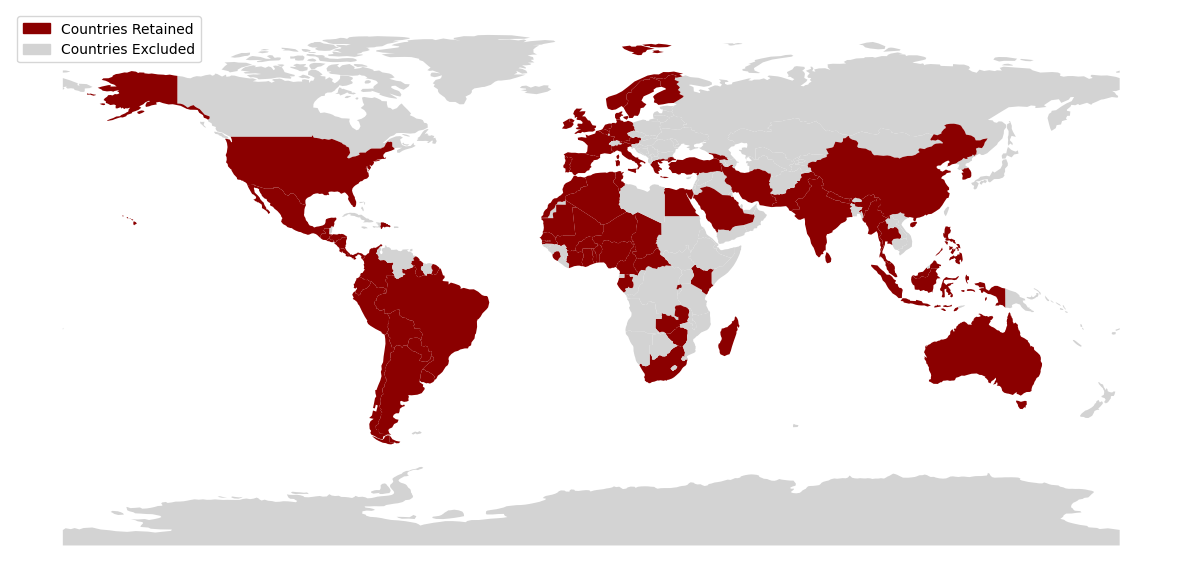

['ARG' 'AUS' 'AUT' 'BEL' 'BEN' 'BFA' 'BOL' 'BRA' 'CAF' 'CHL' 'CHN' 'CIV'
 'CMR' 'COL' 'CRI' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'FIN' 'FRA'
 'GAB' 'GBR' 'GEO' 'GHA' 'GMB' 'GRC' 'GTM' 'GUY' 'HND' 'IDN' 'IND' 'IRL'
 'IRN' 'ITA' 'KEN' 'KOR' 'LKA' 'MAR' 'MDG' 'MEX' 'MLI' 'MMR' 'MRT' 'MYS'
 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'PAK' 'PAN' 'PER' 'PHL' 'PRT' 'PRY'
 'RWA' 'SAU' 'SEN' 'SLE' 'SLV' 'SWE' 'TCD' 'TGO' 'THA' 'TUN' 'TUR' 'URY'
 'USA' 'ZAF' 'ZMB' 'ZWE']


In [10]:
# Define custom colors: Grey for False and a different color for True (e.g., dark blue)
cmap = mcolors.ListedColormap(['lightgrey', 'darkred'])

# Load world map data from Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column to indicate if a country is retained in the analysis
retained_countries = dat.loc[I, 'code'].unique()
world['retained'] = world['iso_a3'].isin(retained_countries)

# Plot the map without the default legend
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='retained',  # Color by inclusion status
           cmap=cmap,           # Custom color map
           legend=False,         # Disable default legend
           ax=ax,
           missing_kwds={'color': 'lightgrey', 'label': 'No Data'})  # Light grey for countries not in dataset

# Create custom legend entries
retained_patch = mpatches.Patch(color='darkred', label='Countries Retained')
excluded_patch = mpatches.Patch(color='lightgrey', label='Countries Excluded')

# Add custom legend with descriptive labels
plt.legend(handles=[retained_patch, excluded_patch], loc='upper left')

# Add title and other formatting
ax.set_axis_off()

# Display the map
plt.show()
print(retained_countries)

### BCCH penalty

In [11]:
# BCCH penalty:
def BCCH(X_stan,y):
    n,p = X_stan.shape
    c = 1.1
    alpha = 0.05
    yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale

    # Pilot estimates
    pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)

    return penalty_BCCH


## POST DOUBLE LASSO

### PDL BCCH penalty

Step 1: Lasso Y using D and Z 

In [13]:
# Calculate BRT
penalty_BCCHyx = BCCH(X_stan, y)
print("lambda_BCCHyx =",penalty_BCCHyx.round(3))

# Run Lasso 
fit_BCCHyx = Lasso(penalty_BCCHyx, max_iter=10000).fit(X_stan, y)
coefs=fit_BCCHyx.coef_

# Calculate residuals
resyx = y-fit_BCCHyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

# Count non-zero coefficients
print("The number of non-zero coefficients in the first stage is =", np.count_nonzero(coefs))

lambda_BCCHyx = 2.623
The number of non-zero coefficients in the first stage is = 0


Step 2: Lasso D using Z

In [14]:
penalty_BCCHdz = BCCH(Z_stan, D)
print("lambda_BCCHdz =",penalty_BCCHdz.round(3))

# Run Lasso
fit_BCCHdz = Lasso(penalty_BCCHdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=D-fit_BCCHdz.predict(Z_stan)

# Count non-zero coefficients
print("The number of non-zero coefficients in the second stage is =", np.count_nonzero(coefs))

lambda_BCCHdz = 1.127
The number of non-zero coefficients in the second stage is = 0


Step 3: Estimate beta

In [15]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
beta_PDL = num/denom

# Display alpha
print("beta_PDL = ",beta_PDL.round(3))

beta_PDL =  -0.132


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\beta}$.

In [16]:
# Calculate the implied variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  1.399


In [17]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/n)

# Display standard error
print("se_PDL = ",se_PDL.round(3))

se_PDL =  0.136


In [18]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = beta_PDL - q * se_PDL
CI_high_PDL = beta_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(3),CI_high_PDL.round(3)))

CI_PDL =  (-0.398, 0.133)
